In [2620]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## PARAMETERS :

In [2621]:
# Simulation :
m_MC = 100 # Number of simulations
T = 50 # Time horizon in years
N = 50 # Number of time steps (daily frequency)
dt = T / N # Time step
initial_population = 10000  # Initial population size (number of contracts at t=0)


# Fund / Premium :
F0 = 100000 # Initial value of the fund / Premium Invested
sigma_equity = 0.20 # Volatility for equity
sigma_property = 0.10 # Volatility for property
PR_weight = 0.2 # Weight of PR in the portfolio
EQ_weight = 0.8 # Weight of EQ in the portfolio

# Liabilities :
RFR = 0.03
rd_rate = 0.022
COMM = 0.014
inflation_rate = 0.02
lapse_rate = 0.15  # Annual lapse rate
cst_cost = 50 # Constant unitary cost

In [2622]:
# Generate the 50€ vector following the inflation :
Expenses = np.zeros(N)
Expenses[1:] = [cst_cost * (1 + inflation_rate) ** i for i in range(1,N)]
Expenses

array([  0.        ,  51.        ,  52.02      ,  53.0604    ,
        54.121608  ,  55.20404016,  56.30812096,  57.43428338,
        58.58296905,  59.75462843,  60.949721  ,  62.16871542,
        63.41208973,  64.68033152,  65.97393815,  67.29341692,
        68.63928525,  70.01207096,  71.41231238,  72.84055863,
        74.2973698 ,  75.78331719,  77.29898354,  78.84496321,
        80.42186247,  82.03029972,  83.67090572,  85.34432383,
        87.05121031,  88.79223451,  90.56807921,  92.37944079,
        94.22702961,  96.1115702 ,  98.0338016 ,  99.99447763,
       101.99436719, 104.03425453, 106.11493962, 108.23723841,
       110.40198318, 112.61002284, 114.8622233 , 117.15946777,
       119.50265712, 121.89271027, 124.33056447, 126.81717576,
       129.35351927, 131.94058966])

## ASSETS :

### Import RFR no VA :

In [2623]:
# Path to your Excel file
file_path = 'EIOPA_RFR_20240331_Term_Structures.xlsx'

# Read Excel file
df = pd.read_excel(file_path, "RFR_spot_no_VA", usecols="C", )
df = df[9:]
df = df.rename(columns={'Unnamed: 18': 'EIOPA EU without VA, MAR'})
rt = np.array(df).T
rt = np.array(rt, np.float64)
rt = rt[0, :N] # Time-varying risk-free rate

In [2624]:
rt

array([0.03514, 0.03035, 0.02783, 0.02637, 0.02549, 0.02502, 0.02477,
       0.02466, 0.02464, 0.0247 , 0.02487, 0.02487, 0.02492, 0.02499,
       0.02498, 0.02486, 0.02466, 0.02446, 0.02427, 0.02415, 0.02409,
       0.02409, 0.02413, 0.02421, 0.02431, 0.02443, 0.02457, 0.02472,
       0.02487, 0.02502, 0.02518, 0.02534, 0.0255 , 0.02566, 0.02581,
       0.02596, 0.02611, 0.02626, 0.0264 , 0.02654, 0.02667, 0.0268 ,
       0.02693, 0.02705, 0.02717, 0.02728, 0.02739, 0.0275 , 0.0276 ,
       0.02771])

### Simulate GBM :

In [2625]:
def simulate_gbm_vec(F0, r, sigma, dt, N, m_MC):
    np.random.seed(123456)#1234)
    # Generate N samples from a GBM with risk-free rate r and volatility sigma
    # r and sigma are assumed to be annualized
    # dt is the time step
    # S0 is the initial value of the process
    S = np.zeros((m_MC, N))
    S[:, 0] = np.full(m_MC, F0)
    for t in range(1, N):
        # Generate m_MC samples of random normal variables
        z = np.random.normal(size=m_MC)
        # Update the stock price for all iterations simultaneously
        S[:, t] = S[:, t - 1] * np.exp((r[t] - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S

(50, 100)(50, 100)


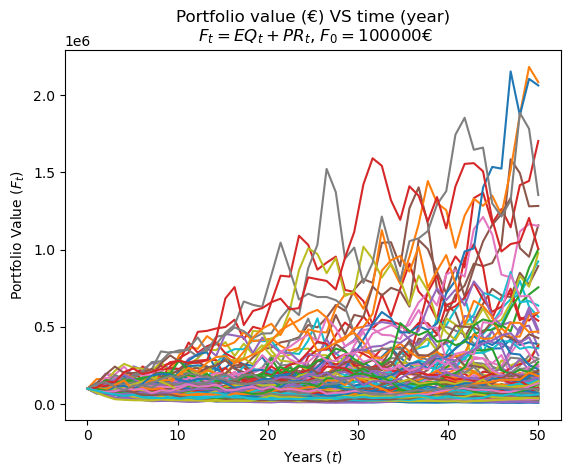

In [2626]:
# Simulate equity and property paths
EQt= simulate_gbm_vec(F0, rt, sigma_equity, dt, N, m_MC)
PRt = simulate_gbm_vec(F0, rt, sigma_property, dt, N, m_MC)

# Calculate the fund value at each time step
fund_value = EQ_weight * EQt + PR_weight * PRt
F = np.squeeze(fund_value)

# Define time interval correctly
time = np.linspace(0,T,N)
# Require numpy array that is the same shape as F
tt = np.full(shape=(m_MC,N), fill_value=time).T
# Check that the dimensions are OK for the plot
print(str(tt.shape) + str(fund_value.T.shape))

plt.plot(tt, fund_value.T);
plt.xlabel("Years $(t)$")
plt.ylabel("Portfolio Value $(F_t)$")
plt.title("Portfolio value (€) VS time (year)\n $F_t = EQ_t + PR_t$, $F_0 = 100000€$")
plt.show()

## LIABILITIES :

### Create a dataframe with years, rates and discount factors :

In [2627]:
EIOPA_yield_curve = pd.DataFrame()
EIOPA_yield_curve['Years'] = np.arange(0, 51, 1)
EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024'] = np.insert(rt, 0, 0)  # EIOPA RFR spot rate no VA, with 0 at year = 0 so that discount = 1
EIOPA_yield_curve['Discount Factors'] = 1 / (1 + EIOPA_yield_curve['EIOPA EU without VA, MARCH 2024']) ** EIOPA_yield_curve['Years']
EIOPA_yield_curve

,Years,"EIOPA EU without VA, MARCH 2024",Discount Factors
0,0,0.00000,1.000000
1,1,0.03514,0.966053
2,2,0.03035,0.941956
3,3,0.02783,0.920950
4,4,0.02637,0.901123
5,5,0.02549,0.881745
6,6,0.02502,0.862196
7,7,0.02477,0.842588
8,8,0.02466,0.822928
9,9,0.02464,0.803264


### Import Life Table ISTATS :

In [2628]:
df_LT = pd.read_excel("LT_M_only.xlsx", skiprows=[0], index_col=0)
df_LT

,Survivors lx,Deaths dx,Probability of death (per thousand) qx,Years lived Lx,Projection probability Px,Life expectancy ex,Info
Age x,,,,,,,
0,100000,249,2.49291,99765,0.999755,80.590,NaN
1,99751,20,0.19564,99741,0.999832,79.790,NaN
2,99731,14,0.14114,99724,0.999876,78.805,NaN
3,99717,11,0.10689,99712,0.999903,77.816,NaN
4,99706,9,0.08633,99702,0.999914,76.825,NaN
...,...,...,...,...,...,...,...
115,0,0,877.05602,0,0.121277,0.638,NaN
116,0,0,892.27829,0,0.106441,0.619,NaN
117,0,0,905.45023,0,0.093581,0.603,NaN


### Create a clean dataframe with the useful data from the life table :

In [2629]:
Life_table = pd.DataFrame()
Life_table['Age'] = np.arange(60, 120, 1)
Life_table['Death probability qx'] = np.array(df_LT['Probability of death (per thousand)  qx'][60:120]) / 1000
Life_table['Cumulative survival probability px'] = (1 - Life_table['Death probability qx']).cumprod()
Life_table

,Age,Death probability qx,Cumulative survival probability px
0,60,0.006468,9.935321e-01
1,61,0.007100,9.864778e-01
2,62,0.007815,9.787684e-01
3,63,0.008665,9.702875e-01
4,64,0.009653,9.609216e-01
5,65,0.010795,9.505482e-01
6,66,0.011728,9.393999e-01
7,67,0.012798,9.273775e-01
8,68,0.013975,9.144174e-01
9,69,0.015660,9.000976e-01


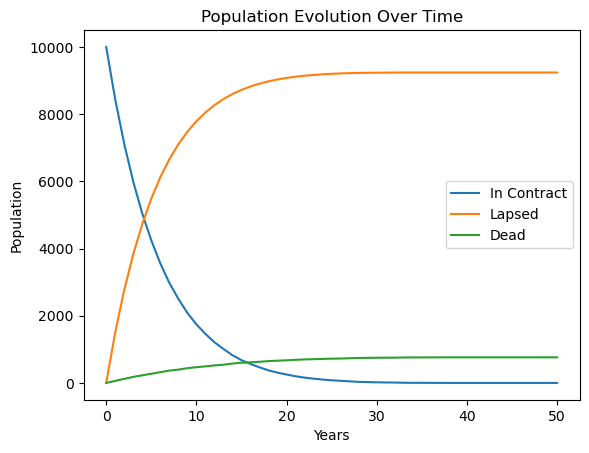

In [2630]:
# Life table (taken from the real italian life table)
life_table = Life_table['Death probability qx']

# Initialize lists to store population data
population_in_contract = [initial_population]
population_lapsed = [0]
population_dead = [0]

# Simulate population evolution over 50 years
for year in range(1, N + 1):
    # Calculate number of deaths
    # deaths = np.random.binomial(population_in_contract[-1], life_table[min(year, max(life_table.keys()))])
    deaths = np.random.binomial(population_in_contract[-1], life_table[year - 1])

    # Calculate number of lapses
    lapses = int(population_in_contract[-1] * lapse_rate)

    # Update population
    population_in_contract.append(max(0, population_in_contract[-1] - deaths - lapses))
    population_lapsed.append(population_lapsed[-1] + lapses)
    population_dead.append(population_dead[-1] + deaths)

# Plot population evolution
years_range = range(N + 1)
plt.plot(years_range, population_in_contract, label='In Contract')
plt.plot(years_range, population_lapsed, label='Lapsed')
plt.plot(years_range, population_dead, label='Dead')
plt.xlabel('Years')
plt.ylabel('Population')
plt.title('Population Evolution Over Time')
plt.legend()
plt.show()


### Computation of the lapse liabilities :

Here in the MC, the "randomness" comes from $(F_t)_t$ : since in case of lapse, the beneficiary gets the value of the fund at the time of lapse, with 20 euros of penalties applied, the lapse liabilities obviously depend on the value of the fund. So we can simulate a vast number of funds at 50 years horizon and then compute (the same vast number of times) the lapse liabilities and finally take the average (expectation).

#### Get the data from the ISTATS life table and the EIOPA term structure :

In [2631]:
px_cumul = Life_table["Cumulative survival probability px"]
discount_factors = EIOPA_yield_curve["Discount Factors"][:-1]

In [2632]:
def lapse_proba(px_cumul, lapse_rate):
    """
    Calculate the lapse probability for each period based on the cumulative survival probability and lapse rate.

    Parameters:
    px_cumul (array-like): Array of cumulative survival probabilities.
    lapse_rate (float): Lapse rate for the insurance policy.

    Returns:
    array-like: Array of lapse probabilities for each period.
    """
    # lapse_p = np.array([px_cumul[i - 1] * (1 - lapse_rate) ** i * lapse_rate for i in range(len(px_cumul))])
    lapse_p = np.zeros(px_cumul.shape)

    for i in range(1, len(px_cumul)):
        lapse_p[i] = px_cumul[i - 1] * (1 - lapse_rate) ** (i - 1) * lapse_rate
    return lapse_p

def lapse_what_do_you_get(Ft, discount_factors):
    """
    Calculate the discounted (present) value of future cash flows based on the discount factors and what you get when you lapse.

    Parameters:
    Ft (array-like): Array of future cash flows.
    discount_factors (array-like): Array of discount factors.

    Returns:
    array-like: Array of present values of future cash flows.
    """
    DPV = (Ft - 20) * discount_factors
    DPV[0] = 0
    return DPV

def lapse_liabilities(RD, lapse_proba, lapse_what_do_you_get):
    """
    Calculate the lapse liabilities i.e. the net present value of future cash flows that will be paid to the policyholders who lapse.
    i.e. the expected value of the discounted cash flows that will be paid to the policyholders who lapse.

    Returns:
    array-like: Array of lapse liabilities.
    """
    return (1 - RD) * lapse_proba * lapse_what_do_you_get

def MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul, lapse_rate, RD):
    """
    Calculate the lapse liabilities using Monte Carlo simulation.

    Parameters:
    m_MC (int): Number of Monte Carlo simulations.
    Ft (array-like): Array of future cash flows.
    discount_factors (array-like): Array of discount factors.
    px_cumul (array-like): Array of cumulative survival probabilities.
    lapse_rate (float): Lapse rate for the insurance policy.
    RD (float): Residual death benefit.

    Returns:
    array-like: Array of lapse liabilities.
    """
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate)

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate lapse liabilities
        lapse_liab = lapse_liabilities(RD, lapse_p, lapse_what_you_get)
        sum += lapse_liab

    # Calculate the lapse liabilities using Monte Carlo simulation
    lapse_liab_MC = sum / m_MC
    return np.array(lapse_liab_MC)

#### Example for the lapse liability :

In [2633]:
# MC :
MC_liab = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
MC_liab

array([0.00000000e+00, 1.39651758e+04, 1.21204556e+04, 1.03167150e+04,
       8.53852074e+03, 7.07000271e+03, 5.80792119e+03, 4.88820323e+03,
       4.11780963e+03, 3.53856437e+03, 2.94655951e+03, 2.58325392e+03,
       2.14952973e+03, 1.75289631e+03, 1.45582688e+03, 1.22906228e+03,
       9.98478409e+02, 7.87124984e+02, 6.46550067e+02, 5.44726667e+02,
       4.45269643e+02, 3.59118507e+02, 2.89874260e+02, 2.26454140e+02,
       1.89352622e+02, 1.44668935e+02, 1.13454117e+02, 8.44643536e+01,
       6.03125299e+01, 4.40610103e+01, 3.11903284e+01, 2.14975818e+01,
       1.51937926e+01, 9.53746636e+00, 5.83643068e+00, 3.66090902e+00,
       2.25127545e+00, 1.24500052e+00, 6.65491122e-01, 3.48098852e-01,
       1.78350326e-01, 8.54557875e-02, 3.96138905e-02, 1.63450093e-02,
       5.83385017e-03, 2.00494079e-03, 6.90834087e-04, 2.08042906e-04,
       5.68254797e-05, 1.35115001e-05])

In [2634]:
MC_liab.sum()

87506.16201837061

In [2635]:
proba = lapse_proba(px_cumul, 0.15)
proba = proba[:50]
what = lapse_what_do_you_get(F[0], discount_factors)
# liab = lapse_liabilities(0.022, proba, what)

Lapse = pd.DataFrame()
Lapse["Proba Lapse"] = proba
Lapse["Discounted Present Value of the Lapse Cash Flows"] = what
Lapse["Lapse Liabilities"] = MC_liab
Lapse.head()

,Proba Lapse,Discounted Present Value of the Lapse Cash Flows,Lapse Liabilities
0,0.000000,0.000000,0.000000
1,0.149030,106518.991543,13965.175778
2,0.125776,98658.452014,12120.455566
3,0.106074,73716.751185,10316.714978
4,0.089382,59925.680079,8538.520738


### Computation of the death liabilities :

Here in the MC, the "randomness" comes from $(F_t)_t$ : since in case of death, the beneficiary gets the maximum between the invested premium and the value of the fund, the death liabilities obviously depend on the value of the fund. So we can simulate a vast number of funds at 50 years horizon and then compute (the same vast number of times) the death liabilities and finally take the average (expectation).

#### Get the data from the ISTATS life table and the EIOPA term structure :

In [2637]:
qx = Life_table["Death probability qx"]

In [2638]:
def death_proba(px_cumul, lapse_rate, qx):
    """
    """
    death_p = np.zeros(px_cumul.shape)
    for k in range(1, len(px_cumul)):
        if k == 1:
            death_p[k] = 1 * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
        else:
            death_p[k] = px_cumul[k - 2] * (1 - lapse_rate) ** (k - 1) * qx[k - 1]
    return death_p

def death_what_do_you_get(Ft, discount_factors, C0):
    """
    Compute the maximum between the invested premium and the value of the fund.
    """
    DPV = np.array([max(C0, value) for value in Ft]) * discount_factors
    DPV[0] = 0
    return DPV

def death_liabilities(RD, death_proba, death_what_do_you_get):
    """
    """
    return (1 - RD) * death_proba * death_what_do_you_get

def MC_death_liabilities(m_MC, F, discount_factors, px_cumul, lapse_rate, RD):
    """
    Calculate the death liabilities using Monte Carlo simulation.
    """
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, life_table)

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = death_what_do_you_get(F[m], discount_factors, F0)

        # Calculate death liabilities
        death_liab = death_liabilities(RD, death_p, death_what_you_get)
        sum += death_liab
    
    # Calculate the death liabilities using Monte Carlo simulation
    death_liab_MC = sum / m_MC
    return np.array(death_liab_MC)

#### Example from the death liability :

In [2639]:
# MC :
d_MC_liab = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
d_MC_liab

array([0.00000000e+00, 6.54394589e+02, 6.24367197e+02, 5.94038028e+02,
       5.54908818e+02, 5.16575911e+02, 4.83363367e+02, 4.40860452e+02,
       4.01290554e+02, 3.74204048e+02, 3.54634547e+02, 3.44295582e+02,
       3.23272867e+02, 2.91807387e+02, 2.65836678e+02, 2.43776473e+02,
       2.23152498e+02, 2.00717098e+02, 1.88184683e+02, 1.75346403e+02,
       1.62111134e+02, 1.47842884e+02, 1.34218921e+02, 1.18108934e+02,
       1.08267987e+02, 9.41109923e+01, 8.52302523e+01, 7.41767411e+01,
       6.13614225e+01, 5.20578784e+01, 4.31240082e+01, 3.43257483e+01,
       2.72912937e+01, 1.98846759e+01, 1.36844305e+01, 9.97708956e+00,
       7.03528196e+00, 4.42154042e+00, 2.63002211e+00, 1.51013170e+00,
       8.50815943e-01, 4.62958829e-01, 2.51807895e-01, 1.19267931e-01,
       4.90117371e-02, 1.93791191e-02, 7.67106843e-03, 2.66736949e-03,
       8.40261892e-04, 2.32082963e-04])

In [2640]:
d_MC_liab.sum()

8458.163202732783

In [2641]:
d_proba = death_proba(px_cumul, 0.15, qx)
d_proba = d_proba[:50]
d_what = death_what_do_you_get(F[0], discount_factors, F0)

Death = pd.DataFrame()
Death["Proba Death"] = d_proba
Death["Discounted Present Value of the Death Cash Flows"] = d_what
Death["Death Liabilities"] = d_MC_liab
Death.head()

,Proba Death,Discounted Present Value of the Death Cash Flows,Death Liabilities
0,0.000000,0.000000,0.000000
1,0.006468,106538.312601,654.394589
2,0.005996,98677.291127,624.367197
3,0.005570,92095.016751,594.038028
4,0.005208,90112.326459,554.908818


### Computation of the lapse and death commission liabilities :

In [2642]:
def L_and_D_COMM_Liabilities(d_proba, l_proba, d_DPV, l_DPV, COMM):
    d_COMM_liabilities = d_proba * d_DPV * COMM
    l_COMM_liabilities = l_proba * l_DPV * COMM
    return np.array(d_COMM_liabilities), np.array(l_COMM_liabilities)

In [2643]:
b = L_and_D_COMM_Liabilities(d_proba, proba, d_what, what, COMM)
b[0].sum() + b[1].sum()

1105.9185107245496

In [2644]:
def L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul):
    """
    Calculate the commission liabilities for death and lapse using Monte Carlo simulation.
    """
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, life_table)[:N]
    # Calculate lapse probabilities
    lapse_p = lapse_proba(px_cumul, lapse_rate)[:N]

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = death_what_do_you_get(F[m], discount_factors, F0)
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate L and D commission liabilities
        L_and_D_COMM_Liab = L_and_D_COMM_Liabilities(death_p, lapse_p, death_what_you_get, lapse_what_you_get, COMM)
        sum += L_and_D_COMM_Liab[0] + L_and_D_COMM_Liab[1]
    
    # Calculate the COMM liabilities using Monte Carlo simulation
    COMM_Liab_MC = sum / m_MC
    return np.array(COMM_Liab_MC)

In [2645]:
L_n_D_COMM_liab = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul)
L_n_D_COMM_liab.sum()

1373.7224469278603

### Computation of the expenses liabilities :

In [2646]:
def Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N):
    Expenses_liab = np.zeros(N)
    Expenses_liab[1] = Expenses[1] * discount_factors[1] * 1 * 1 # (1 - lapse_rate) ** 0 = 1 and px_cumul = 1 at zeroth year
    for i in range(2, N):
        Expenses_liab[i] = Expenses[i] * discount_factors[i] * (1 - lapse_rate) ** (i - 1) * px_cumul[i - 2]
    return Expenses_liab

In [2647]:
Exp_liab = Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N)
Exp_liab.sum()

300.9282630486166

### Creation of a liabilities dataframe :

In [2648]:
def liabilities_summary(lapse_liab, death_liab, comm_liab, exp_liab, N):
    summary = pd.DataFrame()
    summary["Years"] = np.arange(0, N, 1)
    summary["Lapse"] = lapse_liab
    summary["Death"] = death_liab
    summary["COMM"] = comm_liab
    summary["Expenses"] = exp_liab
    summary["Total per year"] = lapse_liab + death_liab + comm_liab + exp_liab
    return summary

In [2649]:
summary = liabilities_summary(MC_liab, d_MC_liab, L_n_D_COMM_liab, Exp_liab, N)
summary

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,13965.175778,654.394589,209.278103,4.926870e+01,14878.117169
2,2,12120.455566,624.367197,182.441226,4.138106e+01,12968.645051
3,3,10316.714978,594.038028,156.186648,3.482826e+01,11101.767918
4,4,8538.520738,554.908818,130.171793,2.931511e+01,9252.916463
5,5,7070.002707,516.575911,108.601330,2.465414e+01,7719.834087
6,6,5807.921187,483.363367,90.059288,2.069949e+01,6402.043328
7,7,4888.203232,440.860452,76.285165,1.734898e+01,5422.697834
8,8,4117.809632,401.290554,64.690596,1.451831e+01,4598.309093
9,9,3538.564367,374.204048,56.011000,1.212936e+01,3980.908771


In [2650]:
TOT_Liabilities = summary["Total per year"].sum()
TOT_Liabilities

97638.97593107988

In [2651]:
BOF = F0 - TOT_Liabilities # a corriger !
BOF

2361.0240689201164

## Stress :

ATTENTION : POUR LES STRESSES IL FAUT TOUJOURS TOUT REFAIRE TOURNER CAR PAR EXEMPLE UNE AUGMENTATION DU TAUX DE LAPSE JOUE AUSSI SUR LES LIABILITIES DE DECES PUISQUE CE TAUX Y APPARAIT... CELA N'IMPACTE DONC PAS QUE LES LIABILITIES DE LAPSE !!

### Stress IR up / down :

### Stress Equity :

### Stress Property :

### Stress Mortality :

### Stress Lapse :

$\textbf{Lapse risk}$ is the risk of loss or adverse change in liabilities due to a change in the expected exercise rates of policyholder options (contractual policyholder rights to fully or partly terminate, surrender, decrease, restrict or suspend insurance cover or permit the insurance policy to lapse). We have :

$\begin{equation}
SCR_{lapse} = max(SCR_{lapseUP}, SCR_{lapseDW}, SCR_{lapseMASS})
\end{equation}$

#### Lapse up / down :

- $\textit{Lapse up}$ : instantaneous permanent increase of $50\%$ in the assumed option exercise rates of the relevant options in all future years that do not exceed $100\%$, i.e $SCR_{lapse\ up} = \Delta BOF | lapse\ up\ shock$
- $\textit{Lapse down}$ : instantaneous permanent decrease of $50\%$ in the assumed option exercise rates of the relevant options in all future years, where the absolute variation do not exceed $20\%$.

In our model, the lapse rate is of $15\%$ which means that the lapse up shock will reach $22,5\%$ and the lapse down $7,5\%$.

In [2652]:
lapse_rate_up = 0.225  # Annual lapse rate in up shock scenario
lapse_rate_dw = 0.075  # Annual lapse rate in down shock scenario

In [2653]:
# MC in up scenario :
MC_liab_up = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate_up, rd_rate)
MC_liab_up

array([0.00000000e+00, 2.09477637e+04, 1.65765054e+04, 1.28646580e+04,
       9.70783144e+03, 7.32895316e+03, 5.48941238e+03, 4.21247342e+03,
       3.23546690e+03, 2.53501523e+03, 1.92464869e+03, 1.53845970e+03,
       1.16719995e+03, 8.67842288e+02, 6.57169032e+02, 5.05852645e+02,
       3.74689557e+02, 2.69314282e+02, 2.01697551e+02, 1.54938689e+02,
       1.15474770e+02, 8.49150329e+01, 6.24941297e+01, 4.45135892e+01,
       3.39364530e+01, 2.36403110e+01, 1.69036675e+01, 1.14740548e+01,
       7.47022664e+00, 4.97580624e+00, 3.21152815e+00, 2.01819987e+00,
       1.30053946e+00, 7.44343047e-01, 4.15307931e-01, 2.37516949e-01,
       1.33173276e-01, 6.71491866e-02, 3.27262517e-02, 1.56077165e-02,
       7.29110683e-03, 3.18525211e-03, 1.34627135e-03, 5.06469218e-04,
       1.64818490e-04, 5.16457977e-05, 1.62251968e-05, 4.45504303e-06,
       1.10949380e-06, 2.40529370e-07])

In [2654]:
# MC in dw scenario :
MC_liab_dw = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate_dw, rd_rate)
MC_liab_dw

array([0.00000000e+00, 6.98258789e+03, 6.59495376e+03, 6.10881609e+03,
       5.50200604e+03, 4.95770650e+03, 4.43205105e+03, 4.05934628e+03,
       3.72131059e+03, 3.48000254e+03, 3.15348293e+03, 3.00860500e+03,
       2.72435902e+03, 2.41768612e+03, 2.18512471e+03, 2.00753532e+03,
       1.77480559e+03, 1.52257472e+03, 1.36100551e+03, 1.24784076e+03,
       1.11000881e+03, 9.74235458e+02, 8.55773048e+02, 7.27531872e+02,
       6.62012041e+02, 5.50418037e+02, 4.69743135e+02, 3.80571664e+02,
       2.95728609e+02, 2.35105643e+02, 1.81113722e+02, 1.35845052e+02,
       1.04482418e+02, 7.13728187e+01, 4.75302357e+01, 3.24439989e+01,
       2.17118528e+01, 1.30665396e+01, 7.60074444e+00, 4.32652544e+00,
       2.41231149e+00, 1.25783526e+00, 6.34530628e-01, 2.84913528e-01,
       1.10663901e-01, 4.13880595e-02, 1.55192268e-02, 5.08594945e-03,
       1.51176764e-03, 3.91172495e-04])

In [2655]:
MC_liab_up.sum(), MC_liab_dw.sum()

(90973.87868975462, 74127.18677927299)

$\textit{And we re-compute all the other liabilities for the up scenario :}$

In [2656]:
# Deaths :
d_MC_liab_LAPSEUP = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate_up, rd_rate)
# Lapse and Death commissions :
L_n_D_COMM_liab_LAPSEUP = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate_up, px_cumul)
# Expenses :
Exp_liab_LAPSEUP = Expenses_liabilities(Expenses, discount_factors, lapse_rate_up, px_cumul, N)
# Summary :
summary_LAPSEUP = liabilities_summary(MC_liab_up, d_MC_liab_LAPSEUP, L_n_D_COMM_liab_LAPSEUP, Exp_liab_LAPSEUP, N)
summary_LAPSEUP

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000
1,1,2.094776e+04,654.394589,3.092333e+02,4.926870e+01,21960.660304
2,2,1.657651e+04,569.275974,2.454406e+02,3.772979e+01,17428.951806
3,3,1.286466e+04,493.832652,1.912258e+02,2.895325e+01,13578.669736
4,4,9.707831e+03,420.600666,1.449878e+02,2.221979e+01,10295.639677
5,5,7.328953e+03,356.997568,1.100238e+02,1.703809e+01,7813.012658
6,6,5.489412e+03,304.570346,8.294045e+01,1.304288e+01,5889.966053
7,7,4.212473e+03,253.278195,6.392691e+01,9.967144e+00,4539.645674
8,8,3.235467e+03,210.202741,4.932451e+01,7.604936e+00,3502.599095
9,9,2.535015e+03,178.718988,3.884691e+01,5.792953e+00,2758.374084


In [2657]:
TOT_Liabilities_LAPSEUP = summary_LAPSEUP["Total per year"].sum()
TOT_Liabilities_LAPSEUP

96958.8360098553

In [2658]:
BOF_LAPSEUP = F0 - TOT_Liabilities_LAPSEUP # a corriger !
BOF_LAPSEUP

3041.163990144705

In [2659]:
d_BOF_LAPSEUP = BOF - BOF_LAPSEUP
d_BOF_LAPSEUP

-680.1399212245888

In [2660]:
SCR_LAPSEUP = max(0, d_BOF_LAPSEUP)
SCR_LAPSEUP

0

$\textit{And we re-compute all the other liabilities for the down scenario :}$

In [2661]:
# Deaths :
d_MC_liab_LAPSEDW = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate_dw, rd_rate)
# Lapse and Death commissions :
L_n_D_COMM_liab_LAPSEDW = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate_dw, px_cumul)
# Expenses :
Exp_liab_LAPSEDW = Expenses_liabilities(Expenses, discount_factors, lapse_rate_dw, px_cumul, N)
# Summary :
summary_LAPSEDW = liabilities_summary(MC_liab_dw, d_MC_liab_LAPSEDW, L_n_D_COMM_liab_LAPSEDW, Exp_liab_LAPSEDW, N)
summary_LAPSEDW

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,6982.587889,654.394589,109.322858,49.268698,7795.574034
2,2,6594.953764,679.458421,104.132690,45.032333,7423.577207
3,3,6108.816092,703.493132,97.517719,41.245581,6951.072525
4,4,5502.006042,715.138315,88.997976,37.779832,6343.922165
5,5,4957.706499,724.478294,81.340069,34.576503,5798.101364
6,6,4432.051047,737.713563,74.004810,31.591744,5275.361165
7,7,4059.346282,732.213925,68.590841,28.814488,4888.965536
8,8,3721.310588,725.301517,63.652934,26.240720,4536.505760
9,9,3480.002535,736.022241,60.352093,23.857241,4300.234110


In [2662]:
TOT_Liabilities_LAPSEDW = summary_LAPSEDW["Total per year"].sum()
TOT_Liabilities_LAPSEDW

99942.05721781965

In [2663]:
BOF_LAPSEDW = F0 - TOT_Liabilities_LAPSEDW # a corriger !
BOF_LAPSEDW

57.9427821803547

In [2664]:
d_BOF_LAPSEDW = BOF - BOF_LAPSEDW
d_BOF_LAPSEDW

2303.0812867397617

In [2665]:
SCR_LAPSEDW = max(0, d_BOF_LAPSEDW)
SCR_LAPSEDW

2303.0812867397617

#### Lapse MASS :

Lapse MASS is about the discontinuance of $40\%$ of the insurance policies (other than group pensions) and for which discontinuance would result in an increase of technical provisions without the risk margin.

In [2666]:
lapse_MASS = 0.4 # lapse mass shock : 40% discontinuance

In [2667]:
def lapse_MASS_proba(px_cumul, lapse_rate, lapse_MASS):
    """
    Calculate the lapse probability for each period based on the cumulative survival probability and lapse rate, 
    in case of MASS Lapse.
    """
    lapse_MASS_p = np.zeros(px_cumul.shape)
    lapse_MASS_p[1] = px_cumul[0] * 1 * lapse_MASS # (1 - lapse_rate) ** (1 - 1) = 1
    for i in range(2, len(px_cumul)):
        lapse_MASS_p[i] = px_cumul[i - 1] * (1 - lapse_rate) ** (i - 2) * lapse_MASS * lapse_rate
    return lapse_MASS_p

def MC_lapse_MASS_liabilities(m_MC, F, discount_factors, px_cumul, lapse_rate, RD, lapse_MASS):
    """
    Calculate the lapse liabilities for lapse MASS using Monte Carlo simulation.
    """
    # Calculate lapse probabilities
    lapse_MASS_p = lapse_MASS_proba(px_cumul, lapse_rate, lapse_MASS)

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate lapse liabilities
        lapse_liab = lapse_liabilities(RD, lapse_MASS_p, lapse_what_you_get)
        sum += lapse_liab

    # Calculate the lapse liabilities using Monte Carlo simulation
    lapse_liab_MC = sum / m_MC
    return np.array(lapse_liab_MC)

def L_MASS_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul, lapse_MASS):
    """
    Calculate the commission liabilities for death and lapse MASS using Monte Carlo simulation.
    """
    # Calculate death probabilities
    death_p = death_proba(px_cumul, lapse_rate, life_table)[:N]
    # Calculate lapse probabilities
    lapse_p = lapse_MASS_proba(px_cumul, lapse_rate, lapse_MASS)[:N]

    sum = 0

    for m in range(m_MC):
        # Calculate what you get when you die
        death_what_you_get = death_what_do_you_get(F[m], discount_factors, F0)
        # Calculate what you get when you lapse
        lapse_what_you_get = lapse_what_do_you_get(F[m], discount_factors)

        # Calculate L and D commission liabilities
        L_and_D_COMM_Liab = L_and_D_COMM_Liabilities(death_p, lapse_p, death_what_you_get, lapse_what_you_get, COMM)
        sum += L_and_D_COMM_Liab[0] + L_and_D_COMM_Liab[1]
    
    # Calculate the COMM liabilities using Monte Carlo simulation
    COMM_Liab_MC = sum / m_MC
    return np.array(COMM_Liab_MC)

In [2668]:
MC_liab_MASS = MC_lapse_MASS_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate, lapse_MASS)

$\textit{And we re-compute all the other liabilities for the MASS scenario :}$

In [2669]:
# Deaths :
d_MC_liab_LAPSEMASS = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
# Lapse and Death commissions :
L_n_D_COMM_liab_LAPSEMASS = L_MASS_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul, lapse_MASS)
# Expenses :
Exp_liab_LAPSEMASS = Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul, N)
# Summary :
summary_LAPSEMASS = liabilities_summary(MC_liab_MASS, d_MC_liab_LAPSEMASS, L_n_D_COMM_liab_LAPSEMASS, Exp_liab_LAPSEMASS, N)
summary_LAPSEMASS

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,37240.468741,654.394589,542.462256,4.926870e+01,38486.594285
2,2,5703.743796,624.367197,90.586456,4.138106e+01,6460.078512
3,3,4854.924696,594.038028,78.001511,3.482826e+01,5561.792498
4,4,4018.127406,554.908818,65.462686,2.931511e+01,4667.814025
5,5,3327.060098,516.575911,55.021374,2.465414e+01,3923.311522
6,6,2733.139382,483.363367,46.044007,2.069949e+01,3283.246242
7,7,2300.330933,440.860452,39.239958,1.734898e+01,2797.780328
8,8,1937.792768,401.290554,33.483810,1.451831e+01,2387.085443
9,9,1665.206761,374.204048,29.194020,1.212936e+01,2080.734185


In [2670]:
TOT_Liabilities_LAPSEMASS = summary_LAPSEMASS["Total per year"].sum()
TOT_Liabilities_LAPSEMASS

81756.66000279835

In [2671]:
BOF_LAPSEMASS = F0 - TOT_Liabilities_LAPSEMASS # a corriger !
BOF_LAPSEMASS

18243.33999720165

In [2672]:
d_BOF_LAPSEMASS = BOF - BOF_LAPSEMASS
d_BOF_LAPSEMASS

-15882.315928281532

In [2673]:
SCR_LAPSEMASS = max(0, d_BOF_LAPSEMASS)
SCR_LAPSEMASS

0

### Expenses :

The $\textbf{Expense risk}$ arises from the variation in the expenses incurred in servicing insurance and reinsurance contracts.

The expense shock is an increase of $10\%$ in future expenses compared to best estimate anticipations, and increase by $1\%$ per annum of the expense inflation rate compared to anticipations, i.e : $SCR_{expenses} = \Delta NAV | expense\ shock$

The underlying assumptions for the expense risk sub-module can be summarised as follows:
- undertakings are exposed to the risk of the change of expenses arising predominantly from: staff costs, cost of commissions to sales intermediaries (on the basis of the contractual terms of the arrangements), cost of IT infrastructure, cost of land and buildings occupied...
- the undertaking operates in a macroeconomic environment where inflation, though subject to fluctuations, is broadly under control (i.e. inflation targeting).

So we have to apply two shocks in one :

In [2674]:
inflation_stress = 0.01 # 1% is the inflation stress
inflation_rate_up = inflation_rate + inflation_stress # shocked inflation rate

In [2675]:
future_expenses_stress = 0.1 # 10% is the future expenses stress
cst_cost_up = cst_cost * (1 + future_expenses_stress) # Constant unitary cost in stressed scenario

In [2676]:
Expenses_up = np.zeros(N)
Expenses_up[1:] = [cst_cost_up * (1 + inflation_rate_up) ** i for i in range(1,N)]
Expenses_up

array([  0.        ,  56.65      ,  58.3495    ,  60.099985  ,
        61.90298455,  63.76007409,  65.67287631,  67.6430626 ,
        69.67235448,  71.76252511,  73.91540086,  76.13286289,
        78.41684878,  80.76935424,  83.19243487,  85.68820791,
        88.25885415,  90.90661977,  93.63381837,  96.44283292,
        99.33611791, 102.31620144, 105.38568749, 108.54725811,
       111.80367586, 115.15778613, 118.61251971, 122.17089531,
       125.83602217, 129.61110283, 133.49943592, 137.50441899,
       141.62955156, 145.87843811, 150.25479125, 154.76243499,
       159.40530804, 164.18746728, 169.1130913 , 174.18648404,
       179.41207856, 184.79444092, 190.33827414, 196.04842237,
       201.92987504, 207.98777129, 214.22740443, 220.65422656,
       227.27385336, 234.09206896])

In [2677]:
Exp_liab_up = Expenses_liabilities(Expenses_up, discount_factors, lapse_rate, px_cumul, N)
Exp_liab_up.sum()

350.83233197575476

$\textit{And we re-compute all the other liabilities :}$

In [2678]:
# Lapses :
MC_liab_EXPENSESUP = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
# Deaths :
d_MC_liab_EXPENSESUP = MC_death_liabilities(m_MC, F, discount_factors, px_cumul[:50], lapse_rate, rd_rate)
# Lapse and Death commissions :
L_n_D_COMM_liab_EXPENSESUP = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul)
# Summary :
summary_EXPENSESUP = liabilities_summary(MC_liab_EXPENSESUP, d_MC_liab_EXPENSESUP, L_n_D_COMM_liab_EXPENSESUP, Exp_liab_up, N)
summary_EXPENSESUP

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,13965.175778,654.394589,209.278103,5.472690e+01,14883.575368
2,2,12120.455566,624.367197,182.441226,4.641608e+01,12973.680065
3,3,10316.714978,594.038028,156.186648,3.944897e+01,11106.388624
4,4,8538.520738,554.908818,130.171793,3.352992e+01,9257.131267
5,5,7070.002707,516.575911,108.601330,2.847527e+01,7723.655214
6,6,5807.921187,483.363367,90.059288,2.414207e+01,6405.485916
7,7,4888.203232,440.860452,76.285165,2.043272e+01,5425.781566
8,8,4117.809632,401.290554,64.690596,1.726654e+01,4601.057317
9,9,3538.564367,374.204048,56.011000,1.456679e+01,3983.346207


In [2679]:
TOT_Liabilities_EXPENSESUP = summary_EXPENSESUP["Total per year"].sum()
TOT_Liabilities_EXPENSESUP

97688.880000007

In [2680]:
BOF_EXPENSESUP = F0 - TOT_Liabilities_EXPENSESUP # a corriger !
BOF_EXPENSESUP

2311.119999992996

In [2681]:
d_BOF_EXPENSESUP = BOF - BOF_EXPENSESUP
d_BOF_EXPENSESUP

49.904068927120534

In [2682]:
SCR_EXPENSESUP= max(0, d_BOF_EXPENSESUP)
SCR_EXPENSESUP

49.904068927120534

### CAT (catastrophy) :

The $\textbf{CAT risk}$ stems from extreme or irregular events whose effects are not sufficiently captured in the other life underwriting risk sub-modules. Examples could be a pandemic event or a nuclear explosion.

The revision shock is an absolute $1.5$ per mille increase in the rate of policyholders dying $\textbf{over the following year}$, and : $SCR_{CAT} = \Delta NAV | CAT_{shock}$.

It is restricted to obligations that are contingent on mortality i.e. where an increase in mortality leads to an increase in technical provisions.

In [2683]:
death_stress = 0.0015 # 1.5 per mille

In [2684]:
Life_table_CAT = Life_table.copy() # we don't want to affect the original life table...
Life_table_CAT["Death probability qx"][0] = Life_table_CAT["Death probability qx"][0] + death_stress
Life_table_CAT

/var/folders/7r/shscmqp1277_1xrsmswqc9q00000gn/T/ipykernel_57765/3005460746.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Life_table_CAT["Death probability qx"][0] = Life_table_CAT["Death probability qx"][0] + death_stress


,Age,Death probability qx,Cumulative survival probability px
0,60,0.007968,9.935321e-01
1,61,0.007100,9.864778e-01
2,62,0.007815,9.787684e-01
3,63,0.008665,9.702875e-01
4,64,0.009653,9.609216e-01
5,65,0.010795,9.505482e-01
6,66,0.011728,9.393999e-01
7,67,0.012798,9.273775e-01
8,68,0.013975,9.144174e-01
9,69,0.015660,9.000976e-01


In [2685]:
qxx = Life_table_CAT["Death probability qx"]
pxx = np.zeros(qxx.shape)
pxx[0] = 1 - qxx[0]

for i in range(1, len(pxx)):
    pxx[i] = pxx[i - 1] * (1 - qxx[i])
Life_table_CAT["Cumulative survival probability px"] = pxx
Life_table_CAT

,Age,Death probability qx,Cumulative survival probability px
0,60,0.007968,9.920321e-01
1,61,0.007100,9.849884e-01
2,62,0.007815,9.772907e-01
3,63,0.008665,9.688226e-01
4,64,0.009653,9.594708e-01
5,65,0.010795,9.491131e-01
6,66,0.011728,9.379816e-01
7,67,0.012798,9.259774e-01
8,68,0.013975,9.130369e-01
9,69,0.015660,8.987387e-01


In [2686]:
px_cumul_CAT = Life_table_CAT["Cumulative survival probability px"][:50]

In [2687]:
MC_liab_CAT = MC_lapse_liabilities(m_MC, F, discount_factors, px_cumul_CAT, lapse_rate, rd_rate)
d_MC_liab_CAT = MC_death_liabilities(m_MC, F, discount_factors, px_cumul_CAT, lapse_rate, rd_rate)
L_n_D_COMM_liab_CAT = L_and_D_COMM_Liabilities_MC(m_MC, COMM, N, lapse_rate, px_cumul_CAT)
Exp_liab_CAT = Expenses_liabilities(Expenses, discount_factors, lapse_rate, px_cumul_CAT, N)

In [2688]:
summary_CAT = liabilities_summary(MC_liab_CAT, d_MC_liab_CAT, L_n_D_COMM_liab_CAT, Exp_liab_CAT, N)
summary_CAT

,Years,Lapse,Death,COMM,Expenses,Total per year
0,0,0.000000,0.000000,0.000000,0.000000e+00,0.000000
1,1,13944.091645,654.394589,208.976286,4.926870e+01,14856.731218
2,2,12102.156526,623.424550,182.165782,4.131859e+01,12949.065445
3,3,10301.139163,593.141170,155.950843,3.477568e+01,11085.006858
4,4,8525.629578,554.071036,129.975264,2.927086e+01,9238.946734
5,5,7059.328665,515.796002,108.437367,2.461692e+01,7708.178952
6,6,5799.152591,482.633602,89.923320,2.066824e+01,6392.377748
7,7,4880.823194,440.194856,76.169993,1.732279e+01,5414.510835
8,8,4111.592707,400.684700,64.592928,1.449639e+01,4591.366727
9,9,3533.221966,373.639088,55.926436,1.211104e+01,3974.898535


In [2689]:
TOT_Liabilities_CAT = summary_CAT["Total per year"].sum()
TOT_Liabilities_CAT

97492.64053521508

In [2690]:
BOF_CAT = F0 - TOT_Liabilities_CAT # a corriger !
BOF_CAT

2507.359464784924

In [2691]:
d_BOF_CAT = BOF - BOF_CAT
d_BOF_CAT

-146.33539586480765

In [2692]:
SCR_CAT = max(0, d_BOF_CAT)
SCR_CAT

0